In [1]:
import numpy as np
import pandas as pd
import os
import shap
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open(r'..\usage\data\test_data.csv') as data:
    data = pd.read_csv(data, low_memory=False)
data.columns = [x.upper() for x in data.columns]
data['DATE'] = data['APPL_SBM_TM'].apply(lambda x:x[0:7])
data.drop(['APPL_SBM_TM','ID'],axis=1,inplace=True)

data.head()

,TARGET,AUTH_TIME_YEAR,AUTH_TIME_MONTH,AUTH_TIME_DAY,AUTH_TIME_WEEKDAY,ID_CARD_EXIST,AUTH_TIME_EXIST,PHONE_EXIST,PHONE_HEAD3,APPL_AUTH_TIME,...,BEFORE_COUNT,ORDER_NAME_FRE,ID_LEN,ORDERNUM_MINUS,ORDERNUM_DIVD,ID_CARD_FIRST,COUNT_REC_INFO,REGION_FRE,FIX_PHONE_FRE,DATE
0,1,-1,-1,-1,-1,1,0,0,NaN,NaN,...,1,1.000000,18,0,1.0,4,9.0,2,1.0,2016-10
1,1,-1,-1,-1,-1,0,0,1,1.0,NaN,...,1,1.000000,18,0,1.0,-1,0.0,-1,1.0,2016-10
2,1,2017,4,7,4,1,1,1,3.0,-19.0,...,1,1.000000,18,0,1.0,5,0.0,-1,1.0,2017-03
3,1,2016,8,21,6,1,1,1,1.0,6.0,...,3,0.666667,20,3,0.0,5,2.0,1,1.0,2016-08
4,1,2016,4,28,3,1,1,1,2.0,351.0,...,1,1.000000,18,1,0.0,3,1.0,-1,0.0,2017-04


In [3]:
os.chdir('..') 
import auto_modeling as am

In [4]:
# 本usage统一用自动划分数据集作为后面的演示
X_train, Y_train, X_test, Y_test, X_time_test, Y_time_test = am.data_split(data=data, test_size=0.3, time_test_type=True)

>> 数据集自动划分成功,按时间升序,后50%样本作为跨时间测试集
>> 训练集样本数: 9328
>> 测试集样本数: 3999
>> 跨时间测试集样本数: 20734
>> 训练集目标情况如下:
   训练集TARGET为 0 的数量: 8343  占比: 89.2%
   训练集TARGET为 1 的数量: 985  占比: 10.2%


In [5]:
keep_cols = ['CREDIT_SCORE', 'APPL_AUTH_TIME', 'BANKPRED', 'NULL_COUNT', 'ID_LEN', 'BANK_RATE_AVG', 'AMT_ORDER_SUM', 
             'ACCOUNT_GRADE', 'OVERTIME_DELTA', 'ORDER_NULL_AVG']

In [6]:
# 转换数据集
X_train_trans, X_test_trans, X_time_test_trans, num_cols, char_cols = am.get_coltype_datalist(X_train, X_test, X_time_test, keep_cols)

In [7]:
# 封装变量处理方法
mapper = am.get_mapper(num_cols, char_cols)

In [8]:
mapper.fit(X_train_trans)
X_train_mapper = mapper.transform(X_train_trans)

## shap值与预测值关系

### LightGBM
#### 每个样本shap值与期望值之和 = 模型预测值的odds_ratio转换
$$ln\frac{1-y}{y}$$
#### 期望值expected_value = 所有样本模型预测值经odds_ratio转换后的均值
$$expected\_value = \frac{1}{M}\sum_{i=1}^{M}ln\frac{1-y_i}{y_i}$$
其实expected_value和模型预测值经odds_ratio转换后的均值并不完全相同，在第14位小数位有1的差异，为什么引起这个差异在后面测试xgboost的时候讲述

In [71]:
model_lgb = LGBMClassifier(random_state=1234)
model_lgb.fit(X_train_mapper,Y_train)

explainer_lgb = shap.TreeExplainer(model_lgb)

# 每个样本各个特征的shap值
shap_values_lgb = explainer_lgb.shap_values(X_train_mapper)
# 期望值
expected_value_lgb = explainer_lgb.expected_value
# 模型预测值 
predict_lgb = model_lgb.predict_proba(X_train_mapper)[:, 1]
# 对模型预测值进行odds_ratio转换
predict_odds_ratio_lgb = np.log(predict_lgb / (1 - predict_lgb))
# 每个样本shap值与期望值之和
shap_sum_lgb = shap_values_lgb.sum(1) + expected_value_lgb
print('所有样本shap值与期望值之和 - 模型预测值odds_ratio转换的值：',
      list(set([round(i,4) for i in shap_sum_lgb - predict_odds_ratio_lgb])))
print('shap库得到的expected_value：', expected_value_lgb)
print('模型预测值经odds_ratio转换后的均值：', predict_odds_ratio_lgb.mean())

所有样本shap值与期望值之和 - 模型预测值odds_ratio转换的值： [-0.0]
shap库得到的expected_value： -3.3545325194123206
模型预测值经odds_ratio转换后的均值： -3.354532519412321


### XGBoost
#### 每个样本shap值与期望值之和是 = 模型预测值的odds_ratio转换
#### 期望值expected_value = 所有样本模型预测值经odds_ratio转换后的均值
可以看出shap库得到的expected_value为-2.235778，模型预测值经odds_ratio转换后的均值为-2.79391，有-0.5的差异，这个差异是在创建树解释器TreeExplainer的时候产生，因为这个类有一个data参数，默认为None，此时在生成解释器的时候，会将每个数路径下的训练样本作为我们的背景数据集（background dataset），然后记录到TreeExplainer生成的对象中，这时对象里面的背景数据集会与X_train_mapper有差异，而expected_value是预测背景数据集求均值得到的，所以expected_value与所有样本模型预测值经odds_ratio转换后的均值有差异。  
如果在创建TreeExplainer的时候传入data，也就是explainer = shap.TreeExplainer(model_xgb, data=X_train_mapper)，这样就会直接使用X_train_mapper作为背景数据集，计算出的expected_value就是所有样本模型预测值经odds_ratio转换后的均值。
至于为什么lightgbm基本无差异，xgboost则差异较大，应该是刚好lightgbm创建的模型将每个数路径下的训练样本作为我们的背景数据集时基本可以等同X_train_mapper，而xgboost则有差异

In [72]:
model_xgb = XGBClassifier(random_state=1234)
model_xgb.fit(X_train_mapper,Y_train)

explainer_xgb = shap.TreeExplainer(model_xgb)

# 每个样本各个特征的shap值
shap_values_xgb = explainer_xgb.shap_values(X_train_mapper)
# 期望值
expected_value_xgb = explainer_xgb.expected_value
# 模型预测值 
predict_xgb = model_xgb.predict_proba(X_train_mapper)[:, 1]
# 对模型预测值进行odds_ratio转换
predict_odds_ratio_xgb = np.log(predict_xgb / (1 - predict_xgb))
# 每个样本shap值与期望值之和
shap_sum_xgb = shap_values_xgb.sum(1) + expected_value_xgb
print('所有样本shap值与期望值之和 - 模型预测值odds_ratio转换的值：',
      list(set([round(i,4) for i in shap_sum_xgb - predict_odds_ratio_xgb])))
print('shap库得到的expected_value：', expected_value_xgb)
print('模型预测值经odds_ratio转换后的均值：', predict_odds_ratio_xgb.mean())

所有样本shap值与期望值之和 - 模型预测值odds_ratio转换的值： [0.0]
shap库得到的expected_value： -2.235778
模型预测值经odds_ratio转换后的均值： -2.79391


In [69]:
explainer = shap.TreeExplainer(model_xgb, data=X_train_mapper)
print('新的expected_value',explainer.expected_value)

新的expected_value -2.793910030637288


### GBDT
#### 每个样本shap值与期望值之和 = 模型预测值的odds_ratio转换
#### 期望值expected_value = 所有样本模型预测值经odds_ratio转换后的均值
可以看到expected_value和模型预测值经odds_ratio转换后的均值在第8位小数位开始有差异，这个差异在前面有说明

In [73]:
model_gbdt = GradientBoostingClassifier(random_state=1234)
model_gbdt.fit(X_train_mapper,Y_train)

explainer_gbdt = shap.TreeExplainer(model_gbdt)

# 每个样本各个特征的shap值
shap_values_gbdt = explainer_gbdt.shap_values(X_train_mapper)
# 期望值
expected_value_gbdt = explainer_gbdt.expected_value
# 模型预测值 
predict_gbdt = model_gbdt.predict_proba(X_train_mapper)[:, 1]
# 对模型预测值进行odds_ratio转换
predict_odds_ratio_gbdt = np.log(predict_gbdt / (1 - predict_gbdt))
# 每个样本shap值与期望值之和f
shap_sum_gbdt = shap_values_gbdt.sum(1) + expected_value_gbdt
print('所有样本shap值与期望值之和 - 模型预测值odds_ratio转换的值：',
      list(set([round(i,4) for i in shap_sum_gbdt - predict_odds_ratio_gbdt])))
print('shap库得到的expected_value：', expected_value_gbdt)
print('模型预测值经odds_ratio转换后的均值：', predict_odds_ratio_gbdt.mean())

所有样本shap值与期望值之和 - 模型预测值odds_ratio转换的值： [0.0]
shap库得到的expected_value： -2.7378472773670883
模型预测值经odds_ratio转换后的均值： -2.7378472802852625


### 随机森林
#### 每个样本shap值与期望值之和 = 模型预测值
#### 期望值expected_value = 所有样本模型预测值的均值
随机森林与其他模型不同，期望值expected_value并不等于所有样本模型预测值经odds_ratio转换后的均值，而是原始预测值的均值，这个是因为作者在源码中有对GBDT、LightGBM、XGBoost进行特殊处理，但随机森林却未做这个处理。  
可以看到expected_value和模型预测值均值有0.003的差异，这个差异在前面有说明。  
但是[2638, 4025, 8356]样本的shap值与期望值之和和模型预测值的差异有一次，为什么有这个异常的原因未发现。

In [38]:
model_rf = RandomForestClassifier(random_state=1234)
model_rf.fit(X_train_mapper,Y_train)

explainer_rf = shap.TreeExplainer(model_rf)

# 每个样本各个特征的shap值，这里用了索引[1]
shap_values_rf = explainer_rf.shap_values(X_train_mapper)[1]
# 期望值
expected_value_rf = explainer_rf.expected_value[1]
# 模型预测值 
predict_rf = model_rf.predict_proba(X_train_mapper)[:, 1]
# 每个样本shap值与期望值之和f
shap_sum_rf = shap_values_rf.sum(1) + expected_value_rf
print('所有样本shap值与期望值之和 - 模型预测值：',
      list(set([round(i,4) for i in shap_sum_rf - predict_rf])))
print('shap库得到的expected_value：', expected_value_rf)
print('模型预测值的均值：', predict_rf.mean())

所有样本shap值与期望值之和 - 模型预测值： [-0.0, 0.1]
shap库得到的expected_value： 0.10447041131556034
模型预测值的均值： 0.10786670559248396


In [46]:
# 从上面的输出可以看到有样本的shap值与期望值之和不等于模型预测值
print('shap值与期望值之和不等于模型预测值的样本:',np.where([round(i,4) != 0 for i in shap_sum_rf - predict_rf]))

shap值与期望值之和不等于模型预测值的样本: (array([2638, 4025, 8356], dtype=int64),)


In [57]:
print('异常样本的shap值与期望值之和',shap_values_rf[[2638, 4025, 8356]].sum(1) + expected_value_rf)
print('异常样本的模型预测值',model_rf.predict_proba(X_train_mapper)[[2638, 4025, 8356],1])

异常样本的shap值与期望值之和 [0.1        0.1        1.00000001]
异常样本的模型预测值 [0.  0.  0.9]


## SHAP值与SHAP交互值的关系

In [58]:
model = LGBMClassifier(random_state=1234)
model.fit(X_train_mapper,Y_train)

explainer = shap.TreeExplainer(model)

# 每个样本各个特征的SH值
shap_values = explainer.shap_values(X_train_mapper)
# 每个样本每两个特征的shap值
shap_interaction_values = explainer.shap_interaction_values(X_train_mapper)

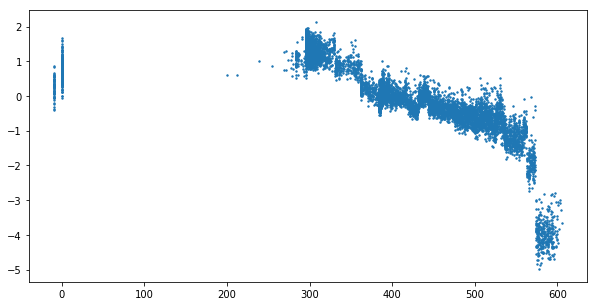

In [68]:
# 首先我们知道每个样本的每个特征都是有一个shap值的，如果用特征值和shap值绘制散点图，就可以显示特征值和shap值的关系
# 以CREDIT_SCORE为例
plt.figure(figsize=[10,5])
plt.scatter(X_train_mapper[:,0], shap_values[:,0], s=2)

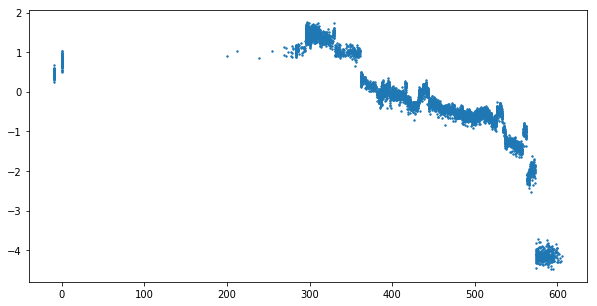

In [70]:
# 用特征值和主要影响绘制散点图
plt.figure(figsize=[10,5])
plt.scatter(X_train_mapper[:,0], shap_interaction_values[:, 0, 0], s=2)

可以看出特征值和shap值绘制散点图在垂直距离上较为分散，而特征值和主要影响绘制散点图则没有那么分散，主要原因是shap值受到了其他变量交互的影响，而主要影响则考虑了交互影响，主要影响的计算如下：
$$\phi _{i,i}=\phi_i-\sum_{j\neq i}\phi _{i,j}$$


In [87]:
print('CREDIT_SCORE特征的主要影响（自己与自己的shap交互值）为:', shap_interaction_values[:, 0, 0])
print('CREDIT_SCORE特征的shap值为:', shap_values[:,0])
print('CREDIT_SCORE特征和其他特征的shap交互值累加为:',shap_interaction_values[:,0,1:].sum(1))

CREDIT_SCORE特征的主要影响（自己与自己的shap交互值）为: [ 0.04019067  1.54846066  0.09746918 ... -0.10330252  0.04792201
  0.63945399]
CREDIT_SCORE特征的shap值为: [-0.20521829  1.1487128   0.62079991 ...  0.33816258 -0.0178521
  1.02926118]
CREDIT_SCORE特征和其他特征的shap交互值累加为: [-0.24540895 -0.39974787  0.52333073 ...  0.4414651  -0.06577411
  0.38980719]


In [88]:
print('CREDIT_SCORE特征的shap值减去和其他特征的shap交互值累加减去主要影响为:', 
      shap_values[:,0] - shap_interaction_values[:,0,1:].sum(1) - shap_interaction_values[:, 0, 0])

CREDIT_SCORE特征的shap值减去和其他特征的shap交互值累加减去主要影响为: [ 8.88178420e-16 -2.88657986e-15 -1.80411242e-16 ... -2.22044605e-16
  1.38777878e-16 -1.44328993e-15]
